In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [4]:
INPUT_DATA_DIR = '../../data/processed/'
INPUT_FILE_NAME = 'squashed_processed_data.pkl'

In [5]:
df = pd.read_pickle(INPUT_DATA_DIR + INPUT_FILE_NAME)
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,harm_vice,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.04,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.04,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.12,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.19,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
#                         min_df = 0.05,     # cut words present in less than 5% of documents
                        max_df = 0.3)      # cut words present in more than 30% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(df['transcript'])
print("done in %0.3fs." % (time() - t0))

done in 2.062s.


In [7]:
from sklearn.decomposition import NMF

t1 = time()

n_topics = 50
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 10
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
print("done in %0.3fs." % (time() - t1))

done in 167.603s.


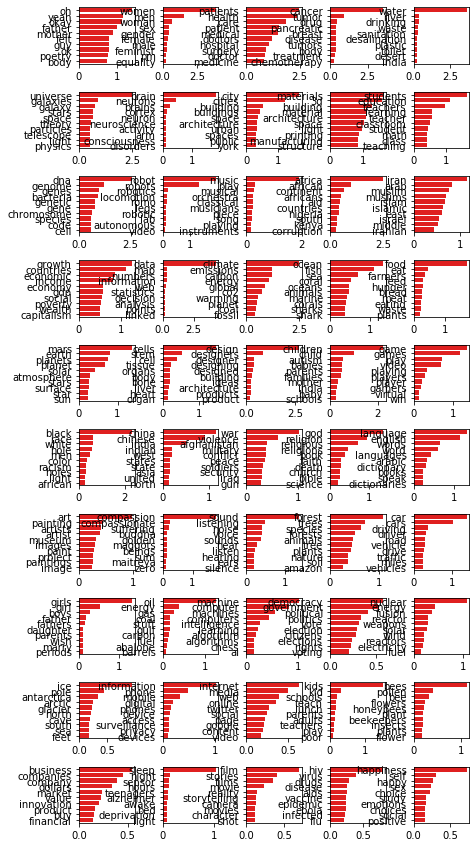

In [8]:
fig, ax = plt.subplots(figsize=(7,15), ncols=5, nrows=10)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,10):
    for col in range(0,5):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [9]:
# Formulating a pipeline to insert a document and extract the topics pertinency
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

# take second element for sort
def takeSecond(elem):
    return elem[1]


In [10]:
def predict_best_topics_processed_string(string):
    t = pipe.transform([string])
    rev_topics = np.where(t>0.01)[1]
    rev_topics_score = t[0][rev_topics]

    rev_topscore = list(zip(rev_topics,rev_topics_score))
    rev_topscore.sort(key = takeSecond, reverse = True)
    return rev_topscore

def predict_best_topics_doc(df,did):
    string = df['transcript'].iloc[did]
    
    return predict_best_topics_processed_string(string)

In [11]:
def show_best_topics_doc(did):

    print('For document #'+str(did)+'...')

    rev_topscore = predict_best_topics_doc(did)
    
    print('\nAll relevant topics (in order of descending relevance): \n')
    for top in range(len(rev_topscore)):
        print(t_words[rev_topscore[top][0]])

    print('\nTranscript:\n',df['transcript'].iloc[document_id][:500],'...')
    print('\nTrue tags from ted_main.csv: \n',df['tags'].iloc[document_id])
    
def show_best_topics_string(string):
    rev_topscore = predict_best_topics_processed_string(string)
    
    print('\nAll relevant topics (in order of descending relevance): \n')
    for top in range(len(rev_topscore)):
        print(t_words[rev_topscore[top][0]])

In [12]:
# correct = 0
# total = len(df.index)
# all_tags = []
# for tr in range(total):
#     print(tr)
#     rev_topscore = predict_best_topics_doc(tr)
#     if rev_topscore != []: 
#         topic_tags = t_words[rev_topscore[0][0]]
#         given_tags = df['tags'][tr]
#     #     print(topic_tags)
#     #     print(given_tags)
#         for label in given_tags:
#             if label not in all_tags:
#                 all_tags.append(label)
        
#         for word in topic_tags:
#             if word in given_tags:
#                 correct += 1


# print('Correct', correct)
# percentage_correct = (correct/len(all_tags))
# print('Percentage correct',percentage_correct)

In [13]:
def predict_tags(rev_topscore, threshold):
    relevant_topics = rev_topscore
    if relevant_topics == []:
        print('No relevant topics, unable to predict tags')
        return

    all_word_score = []
    for top in range(len(relevant_topics)):
        topic = t_words[rev_topscore[top][0]]
        score = rev_topscore[top][1]
        weights = word_strengths[rev_topscore[top][0]]
        combined_score = [0]*len(weights)
        for i in range(len(weights)):
            combined_score[i]= weights[i]*score
        word_score = list(zip(topic,combined_score))
        all_word_score += word_score
    all_word_score.sort(key = takeSecond, reverse = True)
    
    final_tags = []
    for pair in all_word_score:
        if pair[1] > threshold:
            final_tags.append(pair[0])
    return final_tags

In [14]:
def predict_accuracy(df):
    correct = 0
    total = len(df.index)
#     total = 1
    all_tags = []
    tag_count = 0
    threshold = 0
    taggable = 0
    empty = 0
#     print(squash_list)
#     print('should have printed')
    for tr in range(total):
        if tr%100 == 0:
            print(tr)
        tagged = False
        predicted_tags = predict_tags(predict_best_topics_doc(df,tr),threshold)
        given_tags = df['tags'][tr]
#         print(given_tags)
        squash = []
        for label in given_tags:
#             print(label)
            if label in squash_list:
#                 print(label)
                squash.append(label)
                tag_count += 1
                if label not in all_tags:
                    all_tags.append(label)
        left = False
        for squish in squash_list:
            if squish in given_tags:
                left = True
                    
        if predicted_tags != None:
            for word in predicted_tags:
                if word in squash:
                    tagged = True
                    correct += 1
        if tagged:
            taggable += 1
        
        if not left:
            empty += 1
            
    print(all_tags.sort() == squash_list.sort())
    print('Taggable:', taggable)
    print('Tag count:', tag_count)
    print('Percentage tagged:',taggable/total)
    percentage_correct_tag_count = (correct/tag_count)
    print('Percentage correct (tag_count):',percentage_correct_tag_count)


In [15]:
def predict_tags_input(threshold):
    string = input()
    predicted = predict_tags(predict_best_topics_processed_string(string),threshold)
    print(predicted)

In [16]:
your_input = input()
show_best_topics_string(your_input)

 0:00 As New Yorkers, we're often busy looking up at the development going on around us. We rarely stop to consider what lies beneath the city streets. And it's really hard to imagine that this small island village would one day become a forest of skyscrapers. Yet, as an urban archaeologist, that's exactly what I do. I consider landscapes, artifacts to tell the stories of the people who walked these streets before us. Because history is so much more than facts and figures. When people think of archaeology, they usually think of dusty old maps, far off lands, ancient civilizations. You don't think New York City and construction sites. Yet, that's where all the action happens and we're never sure exactly what we're going to find beneath the city streets. Like this wooden well ring which was the base for the construction of a water well. It provided us an opportunity to take a sample of the wood for tree-ring dating, and get a date to confirm the fact that we had indeed found a series of 


All relevant topics (in order of descending relevance): 

['city', 'cities', 'building', 'buildings', 'space', 'architecture', 'urban', 'spaces', 'public', 'york']
['water', 'river', 'drinking', 'waste', 'sanitation', 'desalination', 'plastic', 'toilet', 'desert', 'india']
['children', 'child', 'autism', 'babies', 'parents', 'families', 'mother', 'india', 'baby', 'schools']
['information', 'phone', 'mobile', 'digital', 'phones', 'device', 'access', 'surveillance', 'privacy', 'devices']


In [16]:
# import pickle
# filename = 'nmf.sav'
# pickle.dump(nmf, open(filename, 'wb'))